In [1]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet tavily-python langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00


In [37]:
from google.colab import userdata
from IPython.display import Image, display
from typing_extensions import TypedDict
from typing import Dict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate

In [4]:
google_api_key = userdata.get('GOOGLE_API_KEY')

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model='gemini-1.5-flash',
                                                     api_key=google_api_key)

llm.invoke("What is 2+2?").content

'2 + 2 = 4 \n'

In [60]:
class State(TypedDict):
  query: str
  category: str
  sentiment: str
  response: str

def categorization_node(state: State):
  """Agent node that categorizes the query."""
  query = state["query"]
  prompt = ChatPromptTemplate.from_template(
      "Categorize the following customer query into one of these categories: "
      "Technical, Billing or General. Just return category. Query: {query}"
  )
  category: str = llm.invoke(prompt.format(query=query)).content
  return {"category": category}


def sentiment_node(state: State):
  """Agent node that analyze the sentiment of query and classify it"""
  query = state["query"]
  prompt = ChatPromptTemplate.from_template(
      "Classify the following customer query into one of these sentiments: "
      "Positive, Negative or Neutral. Just return sentiment. Query: {query}"
  )
  sentiment: str = llm.invoke(prompt.format(query=query)).content
  return {"sentiment": sentiment}


def escalate_node(state: State):
  """Agent node that escale query to human agent due to negative sentiment"""
  return {"response": "This query will be answered by human agent due to its negative sentiment."}

def billing_query_node(state: State):
  """ Agent node that handles billing query"""
  query = state["query"]
  prompt = ChatPromptTemplate.from_template(
      "Provide support to the following billing query with respect and friendly tone. Just return answer. Query: {query}"
  )
  response: str = llm.invoke(prompt.format(query=query)).content
  return {"response": response}


def general_query_node(state: State)->str:
  """ Agent node that handles general query"""
  query = state["query"]
  prompt = ChatPromptTemplate.from_template(
      "Provide support to the following general query with respect and friendly tone. Just return answer. Query: {query}"
  )
  response: str = llm.invoke(prompt.format(query=query)).content
  return {"response": response}


def technical_query_node(state: State)->str:
  """ Agent node that handles technical query"""
  query = state["query"]
  prompt = ChatPromptTemplate.from_template(
      "Provide support to the following technical query with respect and friendly tone. Just return answer. Query: {query}"
  )
  response: str = llm.invoke(prompt.format(query=query)).content
  return {"response": response}

def node_decider(state: State):
  if 'Negative' in state["sentiment"]:
    return "escalate_node"
  elif 'Technical' in state['category']:
    return "technical_query_node"
  elif 'Billing' in state['category']:
    return "billing_query_node"
  else:
    return "general_query_node"


In [61]:
builder: StateGraph = StateGraph(State)

builder.add_node("categorization_node", categorization_node)
builder.add_node("sentiment_node", sentiment_node)
builder.add_node("escalate_node", escalate_node)
builder.add_node("billing_query_node", billing_query_node)
builder.add_node("general_query_node", general_query_node)
builder.add_node("technical_query_node", technical_query_node)

builder.add_edge(START, "categorization_node")
builder.add_edge("categorization_node", "sentiment_node")
builder.add_conditional_edges("sentiment_node", node_decider,{
    "escalate_node": 'escalate_node',
    "billing_query_node": 'billing_query_node',
    "general_query_node": 'general_query_node',
    "technical_query_node": 'technical_query_node'
})
builder.add_edge("escalate_node", END)
builder.add_edge("billing_query_node", END)
builder.add_edge("general_query_node", END)
builder.add_edge("technical_query_node", END)

agent: CompiledStateGraph = builder.compile()

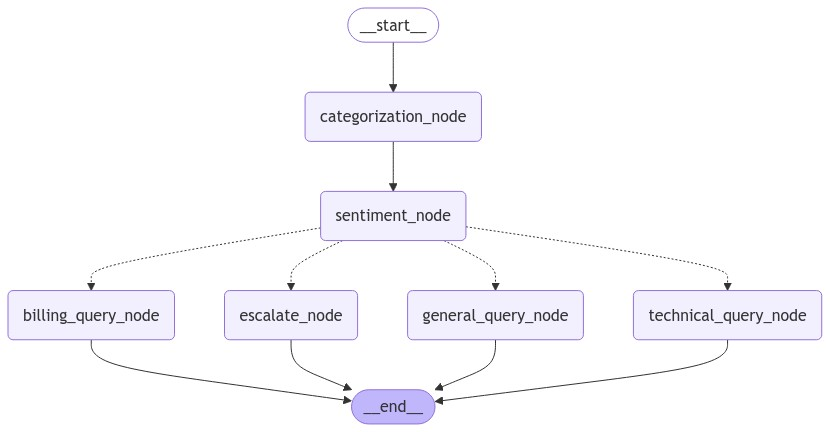

In [62]:
display(Image(agent.get_graph().draw_mermaid_png()))

In [63]:
query = "My internet connection keeps dropping. Can you help?"
result = agent.invoke({"query": query})
result

{'query': 'My internet connection keeps dropping. Can you help?',
 'category': 'Technical \n',
 'sentiment': 'Negative \n',
 'response': 'This query will be answered by human agent due to its negative sentiment.'}

In [64]:
def run_customer_support(query: str) -> Dict[str, str]:
    """Process a customer query through the LangGraph workflow.

    Args:
        query (str): The customer's query

    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    results = agent.invoke({"query": query})
    return {
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"]
    }

In [65]:
query = "My internet connection keeps dropping. Can you help?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")

Query: My internet connection keeps dropping. Can you help?
Category: Technical 

Sentiment: Negative 

Response: This query will be answered by human agent due to its negative sentiment.


In [70]:
query = "How to sign in ChatGPT with my Google account"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: How to sign in ChatGPT with my Google account
Category: Technical 

Sentiment: Neutral 

Response: ChatGPT doesn't currently have a sign-in option using a Google account. It's a standalone AI chatbot. 





In [67]:
 # handle_billing

query = "where can i find my receipt?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: where can i find my receipt?
Category: Billing 

Sentiment: Neutral 

Response: I understand you're looking for your receipt.  Let's get that for you! Can you tell me a little more about what you're looking for?  For example,  what was the purchase for, when did you make it, and what method of payment did you use?  This will help me find your receipt quickly. 😊 





In [68]:
# handle_general

query = "What are your business hours?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")

Query: What are your business hours?
Category: General 

Sentiment: Neutral 

Response: We're here to help you! Our business hours are [Insert Business Hours]. 😊 

